In [2]:
from mindquantum.core.gates import *
from mindquantum.core.circuit import *

import numpy as np
from numpy import pi,cos,sin

In [3]:
%run My_plot.py

%run My_QCircuit.py

%run My_QClassification_Algorithm.py

In [10]:
%run My_QNN.py

%run My_FileIO.py

## 1.Self-defined Circle dataset

In [4]:
def Circ_data_generator(num_samples=1000, random_state=123):
    
    # Random seed
    np.random.seed(random_state)
    
    x_data = []
    y_data = []
    
    R0=0.5
    R1=1.
    dr=0.1
    dtheta_r1 = 0.1
    dtheta_r2 = 0.1
    
    c00,c01=pi/2,pi/2 # Origin point
    c10,c11=pi/2,pi/2 # Origin point
    
    count0=0
    count1=0
    
    thetas = np.linspace(0,2*np.pi*(1-1/(num_samples//2)),num_samples//2)
    
    for k in range(num_samples//2):
        
        # Randomly generate one class 0 data point
        theta = (np.random.rand()-0.5)*dtheta_r1 + thetas[k]
        dr_offest = (np.random.rand()-0.5)*dr
        x1,x2=(R0+dr_offest)*cos(theta)+c00,(R0+dr_offest)*sin(theta)+c01
        
        x_data.append([x1,x2])
        y_data.append(0)
        
        # Randomly generate one class 1 data point
        theta = (np.random.rand()-0.5)*dtheta_r2 + thetas[k]
        dr_offest = (np.random.rand()-0.5)*dr
        x1,x2=(R1+dr_offest)*cos(theta)+c10,(R1+dr_offest)*sin(theta)+c11
        
        x_data.append([x1,x2])
        y_data.append(1)

    x_data=np.array(x_data)
    y_data=np.array(y_data)
    
    return x_data,y_data

def data_repeat(x_data, num_repeats=2):
    x_repeat = x_data
    for k in range(num_repeats-1):
        x_repeat=np.append(x_repeat,x_data,axis=1)
    return x_repeat

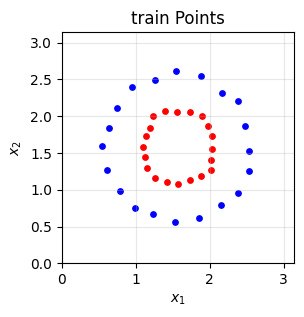

train_data(% of y>0.5): 0.5
x_train_data.shape: (40, 8)


In [5]:
num_train=40
num_valid=100
num_repeats=4

x_train_data, y_train_data=Circ_data_generator(num_train,random_state=126)
x_train_data=data_repeat(x_train_data, num_repeats)

x_valid_data1, y_valid_data1=Circ_data_generator(num_valid,random_state=123)
x_valid_data1=data_repeat(x_valid_data1, num_repeats)


plot_classified_points([[x_train_data[:,0:2], y_train_data]],
                       colors=[["red","blue"]], 
                       xlim=[0,pi],ylim=[0,pi],
                       title='train Points', 
                       figsize=(3,3),
                      ponts_sizes=[15,15]
                      )

# Ensure data balance; otherwise, the model may easily fall into a local minimum
print("train_data(% of y>0.5):",sum(y_train_data)/num_train)

print("x_train_data.shape:",x_train_data.shape)

## 2.Construct the parameterised quantum circuit

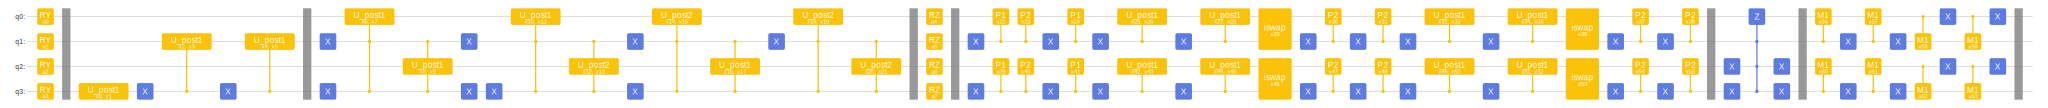

In [6]:
params_enc=["a"+str(k) for k in range(8)]
params_train=["x"+str(k) for k in range(64)]

params_name_dict={"encode_params_name":params_enc,
                  "weight_params_name":params_train,
                  "params_name":params_enc+params_train
                 }

qc = qc_chip(Enc1 = True, 
             Enc2 = True, 
             tomography = False)

display(qc.svg())

## 3.Train

In [7]:
def cost_func(dist, y_tar, label_qubits):
    q_exps = qubit_exps( torch.tensor(dist), qs = label_qubits )
    y_gen = q_exps/2+torch.tensor(0.5)
    
    loss = loss_fn(torch.tensor(y_tar), torch.tensor(y_gen), loss_type="l2norm")
    
    return loss.detach().numpy()

def grad_cost_classical(dist, y_tar, label_qubits):
    dist.requires_grad_(True)
    q_exps = qubit_exps( dist, qs = label_qubits )
    
    y_gen = q_exps/2+torch.tensor(0.5)
    
    
    loss = loss_fn(torch.tensor(y_tar), y_gen, loss_type="l2norm")
    loss.backward()

    grad_classical = dist.grad.detach().numpy()
    grad_classical = grad_classical.reshape(grad_classical.shape[0],1,grad_classical.shape[1])
    
    return grad_classical

In [8]:
def traing(qc,
           x_train_data,
           y_train_data,
           x_test_data,
           y_test_data,
           num_epochs=200,
           n_samples = 2,
           random_seed = 1,
           cost_fn = None,
           learning_rate=0.05,
           spsa_params = {"c":0.2, "min_ck": 0.05, "grad_decay":0.5, "if_grad_smooth":False,"A":30, "spsa_samples":3},
           opt="SPSA-AMSGrad",
           grad_method = "parameter_shift",
           beta_spsa=(0.,0.15),
           beta=(0.9,0.99),
           params_name_dict = None,
           measure_type = "state_vector",
           shots=500,
           print_epoch = 10,
           if_plot = True,
          ):
    """训练1次的函数"""
    
    # 1. Define metric lists
    loss_train_ls=[]
    loss_test_ls=[]
    acc_train_ls=[]
    acc_test_ls=[]
    
    loss_type = "l2norm"
    label_qubits = [2, 3]
    
    # 2.Define the Optimizer
    optimizer=Optimizer(learning_rate,
                        beta=beta,
                        beta_spsa = beta_spsa,
                        epsilon = 1e-8, 
                        spsa_params = spsa_params,
                        optim = opt,
                        grad_method = grad_method
                       )
    
    # 3.Define the QNN
    qnn=QNN(qc,
            params_name_dict,
            measure_type=measure_type,
            interpret=None,
            optimizer=optimizer,
            shots=shots,
           )

    qnn.initialize_parameters(random_seed = random_seed, random_type = "uniform")
    
    # 4.Train
    print("Epoch||loss_train||acc_train||loss_test||acc_test||measure_count")
    start=time.time()
    for epoch in range(num_epochs):
        
        # a. Obtain the gradients
        
        if grad_method == "parameter_shift":
            backward_cost_func = None
        else:
            backward_cost_func = cost_fn
           
        grads = qnn.backward(input_data=x_train_data,
                             y_tar = y_train_data,
                             cost_fn = backward_cost_func,
                             label_qubits = label_qubits 
                            )
        
        # b.Obtain the output and loss from the QNN
        qnn_out = torch.tensor(qnn.forward(x_train_data))
        loss = cost_func(qnn_out, y_train_data, label_qubits)
        
        if grad_method == "parameter_shift":
            grads_classical = grad_cost_classical(qnn_out, y_train_data, label_qubits)
            grads = qnn.combination_grad(grads_ls = [grads_classical, grads])

        qnn.step(grads)

        # c. Record training results
        # c.1 Training set loss and accuracy
        loss_train_ls.append(float(loss))
        acc_train_ls.append(Acc(y_train_data, 
                                (qnn_out[:,0:16]+1e-12)/torch.sum(qnn_out[:,0:16]+1e-12,dim=1).view(-1,1),
                                qs=label_qubits, 
                                data_type = "dist" ))
        
        # c.2 Test set loss and accuracy
        if epoch%5==0 or epoch==num_epochs-1:
            qnn_out_test = torch.tensor(qnn.forward(x_test_data))
            loss_test = cost_func(qnn_out_test, y_test_data,label_qubits)
            loss_test_ls.append(float(loss_test))
            acc_test_ls.append(Acc(y_test_data, 
                                (qnn_out_test[:,0:16]+1e-12)/torch.sum(qnn_out_test[:,0:16]+1e-12,dim=1).view(-1,1),
                                qs=label_qubits, 
                                data_type = "dist" ))
        else:
            loss_test_ls.append(loss_test_ls[-1])
            acc_test_ls.append(acc_test_ls[-1])

        if epoch%print_epoch == 0 or epoch == num_epochs-1:
            print(f"{epoch}||{round(loss_train_ls[-1],5)}||{round(acc_train_ls[-1],4)}||"
                  +f"{round(loss_test_ls[-1],5)}||{round(acc_test_ls[-1],4)}")

    
    print(f"Total time consumed: {round((time.time() - start) / 60, 2)} min")
    
    if if_plot == True:
        plot_training_progress([loss_train_ls,loss_test_ls,acc_train_ls,acc_test_ls],
                               xlabel="Iteration",ylabel="Loss",title="Loss",
                               label=["train_loss","test_loss","train_acc","test_acc"],
                           color=["C0","C1","C2","C3"],figsize=(6,4),save=False,path=None,show=True)
    # Save data
    data_dict = {
        "loss_train_ls":loss_train_ls,
        "loss_test_ls":loss_test_ls,
        "acc_train_ls":acc_train_ls,
        "acc_test_ls":acc_test_ls
    }
    return copy.deepcopy(data_dict)


Repeat:1 

Epoch||loss_train||acc_train||loss_test||acc_test||measure_count


C:\Users\29022\AppData\Local\Temp\ipykernel_5948\1401986283.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  q_exps = qubit_exps( torch.tensor(dist), qs = label_qubits )
C:\Users\29022\AppData\Local\Temp\ipykernel_5948\1401986283.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = loss_fn(torch.tensor(y_tar), torch.tensor(y_gen), loss_type="l2norm")


0||0.58252||0.3||0.57465||0.33
1||0.57749||0.325||0.57465||0.33
2||0.57328||0.4||0.57465||0.33
3||0.56189||0.425||0.57465||0.33
4||0.55182||0.45||0.57465||0.33
5||0.53779||0.425||0.52522||0.45
6||0.52691||0.45||0.52522||0.45
7||0.51634||0.425||0.52522||0.45
8||0.50853||0.4||0.52522||0.45
9||0.50213||0.375||0.52522||0.45
10||0.497||0.375||0.49096||0.39
11||0.49127||0.375||0.49096||0.39
12||0.48675||0.4||0.49096||0.39
13||0.48326||0.4||0.49096||0.39
14||0.48067||0.575||0.49096||0.39
15||0.47876||0.575||0.47679||0.49
16||0.47675||0.5||0.47679||0.49
17||0.47462||0.5||0.47679||0.49
18||0.47249||0.525||0.47679||0.49
19||0.46897||0.525||0.47679||0.49
20||0.46267||0.525||0.4561||0.55
21||0.45617||0.55||0.4561||0.55
22||0.44949||0.575||0.4561||0.55
23||0.4401||0.575||0.4561||0.55
24||0.43244||0.6||0.4561||0.55
25||0.42201||0.675||0.41222||0.7
26||0.4117||0.675||0.41222||0.7
27||0.40126||0.7||0.41222||0.7
28||0.39188||0.7||0.41222||0.7
29||0.38357||0.7||0.41222||0.7
30||0.37379||0.725||0.36699||

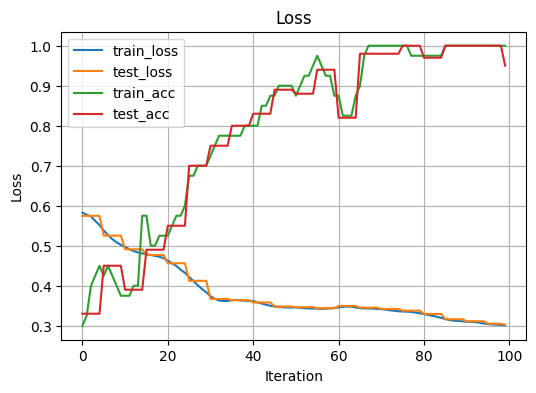

In [11]:
data_dict_all = {
        "loss_train_ls":[],
        "loss_test_ls":[],
        "acc_train_ls":[],
        "acc_test_ls":[]
    }


num_repeats = 1
for r in range(num_repeats):
    print("\nRepeat:"+str(r+1),"\n")
    data_dict = traing(qc,
                       x_train_data,
                       y_train_data,
                       x_valid_data1,
                       y_valid_data1,
                       num_epochs=100,
                       n_samples = 2,
                       random_seed = 123+r,
                       cost_fn = cost_func,
                       learning_rate=0.05,
                       spsa_params = {"c":0.2, "min_ck": 0.05, "grad_decay":0.5, "if_grad_smooth":False,"A":30, "spsa_samples":2},
                       opt="SPSA-AMSGrad",
                       grad_method = "SPSA",
                       beta_spsa=(0.,0.12),
                       beta=(0.9,0.999),
                       params_name_dict = params_name_dict,
                       measure_type = "state_vector",
                       shots=None,
                       print_epoch = 1,
                       if_plot = True,
                      )
    for key in data_dict_all.keys():
        data_dict_all[key].append(data_dict[key])

## 4.Results

train: 1.0 ± 0.0
test: 1.0 ± 0.0


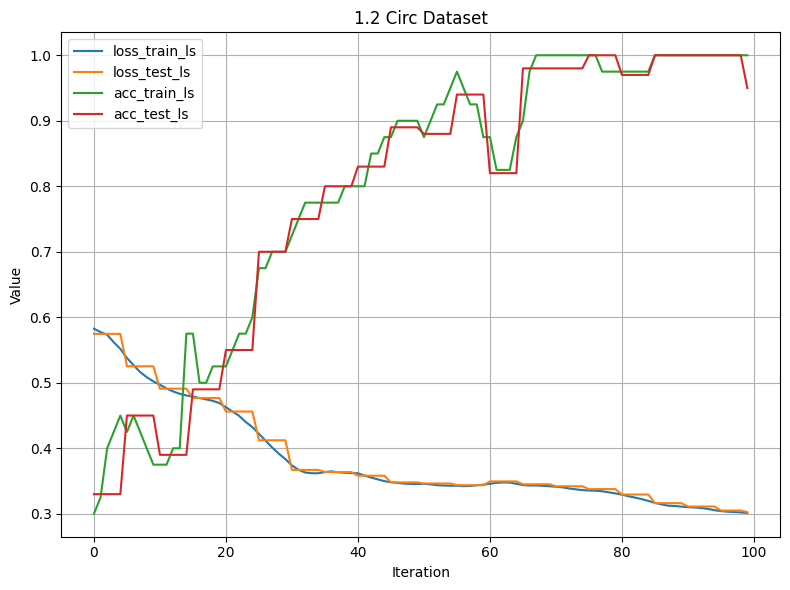

In [12]:

def calc_mean_std(runs):
    """
    Compute the mean and standard deviation of multiple training curves.
    :param runs: lists/arrays, where each element is one training curve.
    :return: mean (NumPy array), std (NumPy array)
    """
    arr = np.array(runs)  # shape: (num_runs, num_iterations)
    mean = arr.mean(axis=0)
    std = arr.std(axis=0)
    return mean, std

dtrain = calc_mean_std(data_dict_all["acc_train_ls"])
print("train:",max(dtrain[0]),"±",dtrain[1][-1])

dtest = calc_mean_std(data_dict_all["acc_test_ls"])
print("test:",max(dtest[0]),"±",dtest[1][-1])

plot_mean_std(data_dict_all,title = "1.2 Circ Dataset")